# 构造词典

In [ ]:
def import_file(self):
    csv_file = pd.read_csv("datasets/image/img2smile.csv")
    smile_list = list(csv_file["smile"])
    ids = list(csv_file["imgid"])
    return smile_list,ids
'''加载数据，csv文件是以imgid，smile存放的'''

In [1]:
import numpy as np
import random
import re
import pickle
from rdkit import Chem
import sys
import time
import torch
from torch.utils.data import Dataset
from collections import Counter
import pandas as pd
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)



def init_from_file():
    csv_file = pd.read_csv("datasets/Chembridge-imageID-SMILE.csv",names=["imgid","smile"])
    smile_list = list(csv_file["smile"])
    ids = list(csv_file["imgid"])
    return smile_list,ids
    
    
def tokenize(smiles):
    regex = '(\[[^\[\]]{1,10}\])'
    smiles = replace_halogen(smiles)
    char_list = re.split(regex, smiles)
    tokenized = []
    for char in char_list:
        if char.startswith('['):
            tokenized.append(char)
        else:
            chars = [unit for unit in char]
            [tokenized.append(unit) for unit in chars]
    tokenized.append('END')
    return tokenized
    
def replace_halogen(string):
    """Regex to replace Br and Cl with single letters"""
    br = re.compile('Br')
    cl = re.compile('Cl')
    string = br.sub('R', string)
    string = cl.sub('L', string)
    return string
  


   
    

        
def build_vocab():
    words = []
    smilelist,_ = init_from_file()
    for smiles in smilelist:
        token = tokenize(smiles.lower())
        for tk in token:
            words.append(tk)
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

if __name__ == '__main__':
    vocab = build_vocab()
    with open("datasets/image/total_vocab.pkl",'wb') as f:
        pickle.dump(vocab,f)
 
        

In [5]:
with open("datasets/image/total_vocab.pkl", 'rb') as f:
    vocab_total = pickle.load(f)

In [6]:
vocab_total.word2idx

{'<pad>': 0,
 '<start>': 1,
 '<end>': 2,
 '<unk>': 3,
 'o': 4,
 '=': 5,
 'c': 6,
 '(': 7,
 '1': 8,
 'n': 9,
 ')': 10,
 '2': 11,
 'f': 12,
 'END': 13,
 '3': 14,
 '[h]': 15,
 '[c@]': 16,
 '[c@h]': 17,
 '[c@@h]': 18,
 '[c@@]': 19,
 'l': 20,
 's': 21,
 '#': 22,
 '/': 23,
 '\\': 24,
 '4': 25,
 '5': 26,
 '[n+]': 27,
 '[o-]': 28,
 '6': 29,
 'b': 30,
 'r': 31,
 '[n-]': 32}

# 加载数据

In [115]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader,Dataset
import os
import pickle
import numpy as np
import nltk
from PIL import Image


class smile_dataset_loader(Dataset):
    def __init__(self,vocab,transform=None):
        csv_file = pd.read_csv("datasets/image/img2smile.csv")
        smile_list = list(csv_file["smile"])
        ids = list(csv_file["imgid"])
        self.data=smile_list
        self.ids = ids
        self.vocab =vocab
        self.transform = transform
    
    def __getitem__(self,index):
        data_id = self.ids[index]
        caption = self.data[index]
        vocab = self.vocab
        image = Image.open(os.path.join("datasets/image/train/",str(index+1)+".png"))
        if self.transform is not None:
            image = self.transform(image)
        tokens = tokenize(caption)
        captions = []
        captions.append(vocab('<start>'))
        captions.extend([vocab(token) for token in tokens])
        captions.append(vocab('<end>'))
        target = torch.Tensor(captions)
        return image, target
            

    
   
    def __len__(self):
        return len(self.data)
    
    def tokenize(smiles):
        regex = '(\[[^\[\]]{1,10}\])'
        smiles = replace_halogen(smiles)
        char_list = re.split(regex, smiles)
        tokenized = []
        for char in char_list:
            if char.startswith('['):
                tokenized.append(char)
            else:
                chars = [unit for unit in char]
                [tokenized.append(unit) for unit in chars]
        tokenized.append('END')
        return tokenized

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths
    
def get_loader(vocab, transform):
    data = data_Loader(vocab=vocab,transform=transform)
    data_lodaer = torch.utils.data.DataLoader(dataset=data,batch_size=40,
                                                 shuffle=True,
                                                 collate_fn=collate_fn)
    return data_lodaer

数据加载 继承了dataset构造数据加载

# 模型构建

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=False)
        resnet.load_state_dict(torch.load(".torch/models/resnet152-b121ed2d.pth"))
        modules = list(resnet.children())[:-2]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, 100)
        self.bn = nn.BatchNorm1d(100, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha


    
    
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, max_seq_length=50):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, 100)
        self.lstm = nn.LSTM(100, 128, 2, batch_first=True)
        self.linear = nn.Linear(128, vocab_size)
        self.max_seg_length = max_seq_length
        self.attention = Attention()
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def init_hidden_state(self):
        init_c = 
        init_h = 
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# 训练

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def main():
    transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
    with open("datasets/image/vocab.pkl", 'rb') as f:
        vocab_train = pickle.load(f)

    data_loader = get_loader(vocab_train,transform) 
    encoder = EncoderCNN().to(device)
    decoder = DecoderRNN(len(vocab_train)).to(device)
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=0.001)
    
    total_step = len(data_loader)
    for epoch in range(6000):
        for i, (images, captions, lengths) in enumerate(data_loader):
            
            # Set mini-batch dataset
            images = images.to(device)
            captions = captions.to(device)
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch+1, 10, i+1, total_step, loss.item(), np.exp(loss.item()))) 
                
            # Save the model checkpoints
            if (i+1) % 50000 == 0:
                torch.save(decoder.state_dict(), os.path.join(
                    "datasets/images", 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    "datasets/images", 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                
main()

Epoch [1/10], Step [0/45], Loss: 3.4441, Perplexity: 31.3149


KeyboardInterrupt: 

In [ ]:
#采样

In [17]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import pickle 
import os
from torchvision import transforms 
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    if transform is not None:
        image = transform(image).unsqueeze(0)
    return image
def sample_smlie(sample_image):
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    # Load vocabulary wrapper
    with open(".torch/models/total_vocab.pkl", 'rb') as f:
        vocab = pickle.load(f)

    encoder = EncoderCNN()
    decoder = DecoderRNN(len(vocab))
    
    encoder.load_state_dict(torch.load(".torch/models/encoder-12-5000.ckpt",map_location='cpu'))
    decoder.load_state_dict(torch.load(".torch/models/decoder-12-5000.ckpt",map_location='cpu'))
    encoder.eval()
    decoder.eval()
    image = load_image(sample_image, transform)
    image_tensor = image
    feature = encoder(image_tensor)
    sampled_ids = decoder.sample(feature)
    sampled_ids = sampled_ids[0].numpy()          # (1, max_seq_length) -> (max_seq_length)
    
    # Convert word_ids to words
    sampled_caption = []
    for word_id in sampled_ids:
        word = vocab.idx2word[word_id]
        sampled_caption.append(word)
        if word == '<end>':
            break
    sentence = ' '.join(sampled_caption)
    sentence =  re.sub('\s+', '', sentence).strip()
    # Print out the image and the generated caption
    print (sentence)
    image = Image.open(sample_image)
    plt.imshow(np.asarray(image))
    return sentence

<start>CC1=CC=C(C2=CC=C(C3=NC=CN3CCCO)C=C2)O1<end>


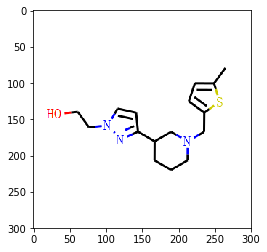

In [27]:
imgs = sample_smlie("datasets/image/test/1603.png")


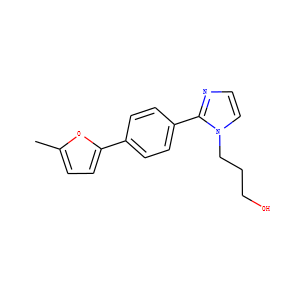

In [40]:
Image.open('1e.png')

In [36]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
 
template = rdkit.Chem.MolFromSmiles(x)
tmp=AllChem.Compute2DCoords(template)
Draw.MolsToImage(template)
#Draw.MolToFile(template,'1e.png')


In [39]:
Draw.MolsToImage(template)

TypeError: object of type 'Mol' has no len()

In [32]:
import difflib
def get_equal_rate_1(str1, str2):
     return difflib.SequenceMatcher(None, str1, str2).quick_ratio()

In [36]:
vocab.idx2word

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: 'o',
 5: '=',
 6: 'c',
 7: '(',
 8: '1',
 9: 'n',
 10: ')',
 11: '2',
 12: 'f',
 13: 'END',
 14: '3',
 15: '[h]',
 16: '[c@]',
 17: '[c@h]',
 18: '[c@@h]',
 19: '[c@@]',
 20: 'l',
 21: 's',
 22: '#',
 23: '/',
 24: '\\',
 25: '4',
 26: '5',
 27: '[n+]',
 28: '[o-]',
 29: '6',
 30: 'b',
 31: 'r',
 32: '[n-]'}

In [5]:
csv_file = pd.read_csv("datasets/Chembridge-imageID-SMILE.csv",names=["imgid","smile"])
csv_file["imgid"][1600]

'CC(C)(C)C1CCCN(C(=O)C2=CN=CN=C2)CC1'

# attentionmox

In [1]:
import numpy as np
import random
import re
import pickle
from rdkit import Chem
import sys
import time
import torch
from torch.utils.data import Dataset
from collections import Counter
import pandas as pd
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)



def init_from_file():
    csv_file = pd.read_csv("datasets/Chembridge-imageID-SMILE.csv",names=["imgid","smile"])
    smile_list = list(csv_file["smile"])
    ids = list(csv_file["imgid"])
    return smile_list,ids
    
    
def tokenize(smiles):
    regex = '(\[[^\[\]]{1,10}\])'
    smiles = replace_halogen(smiles)
    char_list = re.split(regex, smiles)
    tokenized = []
    for char in char_list:
        if char.startswith('['):
            tokenized.append(char)
        else:
            chars = [unit for unit in char]
            [tokenized.append(unit) for unit in chars]
    tokenized.append('END')
    return tokenized
    
def replace_halogen(string):
    """Regex to replace Br and Cl with single letters"""
    br = re.compile('Br')
    cl = re.compile('Cl')
    string = br.sub('R', string)
    string = cl.sub('L', string)
    return string
  


   
    

        
def build_vocab():
    words = []
    smilelist,_ = init_from_file()
    for smiles in smilelist:
        token = tokenize(smiles)
        for tk in token:
            words.append(tk)
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

if __name__ == '__main__':
    vocab = build_vocab()
    with open("datasets/image/total_vocab.pkl",'wb') as f:
        pickle.dump(vocab,f)
 

In [2]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data import DataLoader,Dataset
import os
import pickle
import numpy as np
import nltk
from PIL import Image


class smile_dataset_loader(Dataset):
    def __init__(self,vocab,transform=None):
        csv_file = pd.read_csv("datasets/image/img2smile.csv")
        smile_list = list(csv_file["smile"])
        ids = list(csv_file["imgid"])
        self.data=smile_list
        self.ids = ids
        self.vocab =vocab
        self.transform = transform
    
    def __getitem__(self,index):
        data_id = self.ids[index]
        caption = self.data[index]
        vocab = self.vocab
        image = Image.open(os.path.join("datasets/image/train/",str(index+1)+".png"))
        if self.transform is not None:
            image = self.transform(image)
        tokens = tokenize(caption)
        captions = []
        captions.append(vocab('<start>'))
        captions.extend([vocab(token) for token in tokens])
        captions.append(vocab('<end>'))
        target = torch.Tensor(captions)
        return image, target
            

    
   
    def __len__(self):
        return len(self.data)
    
    def tokenize(smiles):
        regex = '(\[[^\[\]]{1,10}\])'
        smiles = replace_halogen(smiles)
        char_list = re.split(regex, smiles)
        tokenized = []
        for char in char_list:
            if char.startswith('['):
                tokenized.append(char)
            else:
                chars = [unit for unit in char]
                [tokenized.append(unit) for unit in chars]
        tokenized.append('END')
        return tokenized

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths
    
def get_loader(vocab, transform):
    data = smile_dataset_loader(vocab=vocab,transform=transform)
    data_lodaer = torch.utils.data.DataLoader(dataset=data,batch_size=40,
                                                 shuffle=True,
                                                 collate_fn=collate_fn)
    return data_lodaer

In [3]:
transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
with open("datasets/image/total_vocab.pkl", 'rb') as f:
    vocab_train = pickle.load(f)
data_loading = get_loader(vocab_train,transform)


In [4]:
for i,(imgs, caps, caplens) in enumerate(data_loading):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


In [ ]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.
    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

def save_checkpoint(data_name, epoch, epochs_since_improvement, encoder, decoder, encoder_optimizer, decoder_optimizer,
                    bleu4, is_best):
    """
    Saves model checkpoint.
    :param data_name: base name of processed dataset
    :param epoch: epoch number
    :param epochs_since_improvement: number of epochs since last improvement in BLEU-4 score
    :param encoder: encoder model
    :param decoder: decoder model
    :param encoder_optimizer: optimizer to update encoder's weights, if fine-tuning
    :param decoder_optimizer: optimizer to update decoder's weights
    :param bleu4: validation BLEU-4 score for this epoch
    :param is_best: is this checkpoint the best so far?
    """
    state = {'epoch': epoch,
             'epochs_since_improvement': epochs_since_improvement,
             'bleu-4': bleu4,
             'encoder': encoder,
             'decoder': decoder,
             'encoder_optimizer': encoder_optimizer,
             'decoder_optimizer': decoder_optimizer}
    filename = 'checkpoint_' + data_name + '.pth.tar'
    torch.save(state, filename)
    # If this checkpoint is the best so far, store a copy so it doesn't get overwritten by a worse checkpoint
    if is_best:
        torch.save(state, 'BEST_' + filename)

class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, shrink_factor):
    """
    Shrinks learning rate by a specified factor.
    :param optimizer: optimizer whose learning rate must be shrunk.
    :param shrink_factor: factor in interval (0, 1) to multiply learning rate with.
    """

    print("\nDECAYING learning rate.")
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * shrink_factor
    print("The new learning rate is %f\n" % (optimizer.param_groups[0]['lr'],))

def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.
    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """

    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

MAX_LENGTH = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def cuda_variable(tensor):
    if torch.cuda.is_available():
        return Variable(tensor.cuda())
    else:
        return Variable(tensor)

class EncoderCNN(nn.Module):
    def __init__(self, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=False)
        resnet.load_state_dict(torch.load(".torch/models/resnet152-b121ed2d.pth"))
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))
        self.fine_tune()

    def forward(self, images):

        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)
        return out

    def fine_tune(self, fine_tune=True):
        for p in self.resnet.parameters():
            p.requires_grad = False
        for c in list(self.resnet.children())[5:]:
            for p in c.parameters():
                p.requires_grad = fine_tune

class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)
        return attention_weighted_encoding, alpha

class AttnDecoderRNN(nn.Module):

    def __init__(self, attention_dim, embed_dim, decoder_dim, vocab_size, encoder_dim=2048, dropout=0.5):
        super(AttnDecoderRNN, self).__init__()
        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)   # linear layer to create a sigmoid-activated gate
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def load_pretrained_embeddings(self, embeddings):
        self.embedding.weight = nn.Parameter(embeddings)

    def fine_tune_embeddings(self, fine_tune=True):
        for p in self.embedding.parameters():
            p.requires_grad = fine_tune

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

    def forward(self, encoder_out, encoded_captions, caption_lengths):
        """
        :return: scores for vocabulary, sorted encoded captions, decode lengths, weights
        """
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        embeddings = self.embedding(encoded_captions)

        h, c = self.init_hidden_state(encoder_out)

        decode_lengths = [c-1 for c in caption_lengths]

        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        for t in range(max(decode_lengths)):
            batch_size_t = sum([l > t for l in decode_lengths ])
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t], h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

#from model import EncoderCNN, AttnDecoderRNN

#from data_loader import get_loader
#from nltk.translate.bleu_score import corpus_bleu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train():
    transform = transforms.Compose([ 
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(), 
            transforms.Normalize((0.485, 0.456, 0.406), 
                                 (0.229, 0.224, 0.225))])
    with open("datasets/image/total_vocab.pkl", 'rb') as f:
        vocab_train = pickle.load(f)
    data_loading = get_loader(vocab_train,transform)
    encoder = EncoderCNN().to(device)
    decoder = AttnDecoderRNN(512,512,512,len(vocab_train)).to(device)
    encoder.train()
    decoder.train()
    criterions = nn.CrossEntropyLoss()
    encoder.fine_tune(False)
    decoder_optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, decoder.parameters()),lr=0.001)
    losses = 1000
    for epoch in range(100):
        for i, (imgs, caps, caplens) in enumerate(data_loading):
            imgs = imgs.to(device)
            caps = caps.to(device)
            imgs = encoder(imgs)
            
            scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
            scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
            targets = caps_sorted[:, 1:]
            targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)
            
            loss = criterions(scores, targets)
            
            decoder_optimizer.zero_grad()
            loss.backward()
            #losses = loss.item()
            decoder_optimizer.step()
            
            if losses<loss.item():
                torch.save(decoder.state_dict(), os.path.join(
                    "datasets/images", 'newdecoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    "datasets/images", 'newencoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            if i%5 ==0:
                 print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                      .format(epoch+1, 10, i+1, 9000, loss.item(), np.exp(loss.item()))) 
        '''    if i % 9000==0:
                torch.save(decoder.state_dict(), os.path.join(
                    "datasets/images", 'newdecoder-{}-{}.ckpt'.format(epoch+1, i+1)))
                torch.save(encoder.state_dict(), os.path.join(
                    "datasets/images", 'newencoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            
            
            
        '''   
train()

In [ ]:
import pickle
import time
import argparse

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

from model import EncoderCNN, AttnDecoderRNN

from data_loader import get_loader
from nltk.translate.bleu_score import corpus_bleu
from utils import *

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

parser = argparse.ArgumentParser()
parser.add_argument('--data_name', type=str, default='coco_5_cap_per_img_5_min_word_freq')
parser.add_argument('--model_path', type=str, default='models/' , help='path for saving trained models')
parser.add_argument('--crop_size', type=int, default=224 , help='size for randomly cropping images')
parser.add_argument('--vocab_path', type=str, default='data/vocab.pkl', help='path for vocabulary wrapper')
parser.add_argument('--image_dir', type=str, default='data/resized2014', help='directory for resized images')
parser.add_argument('--image_dir_val', type=str, default='data/val2014_resized', help='directory for resized images')
parser.add_argument('--caption_path', type=str, default='data/annotations/captions_train2014.json', help='path for train annotation json file')
parser.add_argument('--caption_path_val', type=str, default='data/annotations/captions_val2014.json', help='path for val annotation json file')
parser.add_argument('--log_step', type=int , default=100, help='step size for prining log info')
parser.add_argument('--save_step', type=int , default=1000, help='step size for saving trained models')

# Model parameters
parser.add_argument('--embed_dim', type=int , default=512, help='dimension of word embedding vectors')
parser.add_argument('--attention_dim', type=int , default=512, help='dimension of attention linear layers')
parser.add_argument('--decoder_dim', type=int , default=512, help='dimension of decoder rnn')
parser.add_argument('--dropout', type=float , default=0.5)
parser.add_argument('--start_epoch', type=int, default=0)
parser.add_argument('--epochs', type=int, default=120)
parser.add_argument('--epochs_since_improvement', type=int, default=0)
parser.add_argument('--batch_size', type=int, default=32)
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--encoder_lr', type=float, default=1e-4)
parser.add_argument('--decoder_lr', type=float, default=4e-4)
parser.add_argument('--checkpoint', type=str, default='ckpt/BEST_checkpoint_coco_5_cap_per_img_5_min_word_freq.pth.tar' , help='path for checkpoints')
parser.add_argument('--grad_clip', type=float, default=5.)
parser.add_argument('--alpha_c', type=float, default=1.)
parser.add_argument('--best_bleu4', type=float, default=0.)
parser.add_argument('--fine_tune_encoder', type=bool, default='False' , help='fine-tune encoder')

args = parser.parse_args()
print(args)



def train(train_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, epoch):
    decoder.train()
    encoder.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    for i, (imgs, caps, caplens) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to GPU, if available
        imgs = imgs.to(device)
        caps = caps.to(device)
        imgs = encoder(imgs)

        # scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)

        targets = caps_sorted[:, 1:]
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        loss = criterion(scores, targets)
        loss += args.alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        decoder_optimizer.zero_grad()
        if encoder_optimizer is not None:
            encoder_optimizer.zero_grad()
        loss.backward()

        if args.grad_clip is not None:
            clip_gradient(decoder_optimizer, args.grad_clip)
            if encoder_optimizer is not None:
                clip_gradient(encoder_optimizer, args.grad_clip)

        decoder_optimizer.step()
        if encoder_optimizer is not None:
            encoder_optimizer.step()

        top5 = accuracy(scores, targets, 5)
        losses.update(loss.item(), sum(decode_lengths))
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % args.log_step == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Load Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})'.format(epoch, i, len(train_loader),
                                                                          batch_time=batch_time,
                                                                          data_time=data_time, loss=losses,
                                                                          top5=top5accs))

def validate(val_loader, encoder, decoder, criterion):
    """
    Performs one epoch's validation.
    :param val_loader: DataLoader for validation data.
    :param encoder: encoder model
    :param decoder: decoder model
    :param criterion: loss layer
    :return: BLEU-4 score
    """
    decoder.eval()  # eval mode (no dropout or batchnorm)
    if encoder is not None:
        encoder.eval()

    batch_time = AverageMeter()
    losses = AverageMeter()
    top5accs = AverageMeter()

    start = time.time()

    references = list()  # references (true captions) for calculating BLEU-4 score
    hypotheses = list()  # hypotheses (predictions)

    # Batches
    for i, (imgs, caps, caplens, allcaps) in enumerate(val_loader):

        # Move to device, if available
        imgs = imgs.to(device)
        caps = caps.to(device)

        # Forward prop.
        if encoder is not None:
            imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)

        # Since we decoded starting with <start>, the targets are all words after <start>, up to <end>
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        # pack_padded_sequence is an easy trick to do this
        scores_copy = scores.clone()
        scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
        targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

        # Calculate loss
        loss = criterion(scores, targets)

        # Add doubly stochastic attention regularization
        loss += args.alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

        # Keep track of metrics
        losses.update(loss.item(), sum(decode_lengths))
        top5 = accuracy(scores, targets, 5)
        top5accs.update(top5, sum(decode_lengths))
        batch_time.update(time.time() - start)

        start = time.time()

        if i % args.log_step == 0:
            print('Validation: [{0}/{1}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Top-5 Accuracy {top5.val:.3f} ({top5.avg:.3f})\t'.format(i, len(val_loader), batch_time=batch_time,
                                                                            loss=losses, top5=top5accs))

        # Store references (true captions), and hypothesis (prediction) for each image
        # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
        # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]

        # References
        # allcaps = allcaps[sort_ind]  # because images were sorted in the decoder
        for j in range(allcaps.shape[0]):
            img_caps = allcaps[j].tolist()
            img_captions = list(
                map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<pad>']}],
                    img_caps))  # remove <start> and pads
            references.append(img_captions)

        # Hypotheses
        _, preds = torch.max(scores_copy, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, p in enumerate(preds):
            temp_preds.append(preds[j][:decode_lengths[j]])  # remove pads
        preds = temp_preds
        hypotheses.extend(preds)

        assert len(references) == len(hypotheses)

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses, emulate_multibleu=True)

    print(
        '\n * LOSS - {loss.avg:.3f}, TOP-5 ACCURACY - {top5.avg:.3f}, BLEU-4 - {bleu}\n'.format(
            loss=losses,
            top5=top5accs,
            bleu=bleu4))

    return bleu4

if __name__ == '__main__':
    main(args)

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=False)
        resnet.load_state_dict(torch.load(".torch/models/resnet152-b121ed2d.pth"))
        modules = list(resnet.children())[:-2]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(2048, 100)
        
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.linear(features)
        return features

In [4]:
en2 = EncoderCNN()

In [5]:
print(en2)

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, ker

)
